This notebook provides examples to go along with the [textbook](http://underactuated.csail.mit.edu/dp.html).  I recommend having both windows open, side-by-side!

[Click here](http://underactuated.csail.mit.edu/drake.html#notebooks) for instructions on how to run the notebook on Deepnote and/or Google Colab.

In [38]:
from time import sleep

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, clear_output, display
from matplotlib import cm
from pydrake.all import (
    DiagramBuilder,
    DiscreteAlgebraicRiccatiEquation,
    DynamicProgrammingOptions,
    FittedValueIteration,
    LeafSystem,
    LinearSystem,
    LogVectorOutput,
    MathematicalProgram,
    MeshcatVisualizerCpp,
    MultilayerPerceptron,
    PerceptronActivationType,
    PeriodicBoundaryCondition,
    Polynomial,
    RandomGenerator,
    Rgba,
    RigidTransform,
    RotationMatrix,
    SceneGraph,
    Simulator,
    Solve,
    StartMeshcat,
    SymbolicVectorSystem,
    Variable,
    Variables,
    WrapToSystem,
    ZeroOrderHold,
)
from pydrake.examples.acrobot import AcrobotGeometry, AcrobotPlant
from pydrake.examples.pendulum import PendulumGeometry, PendulumParams, PendulumPlant

from underactuated.jupyter import AdvanceToAndVisualize, running_as_notebook
from underactuated.meshcat_cpp_utils import interact, plot_surface
from underactuated.optimizers import Adam
from underactuated.pendulum import PendulumVisualizer

plt.rcParams.update({"savefig.transparent": True})


In [39]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

Meshcat is now available at http://localhost:7003


# Value Iteration for the Simple Pendulum

INFO:drake:Computing transition and cost matrices.
INFO:drake:Done computing transition and cost matrices.
INFO:drake:Running value iteration.
INFO:drake:Value iteration converged to requested tolerance.


Simulating...
simulating...  done.
generating animation...


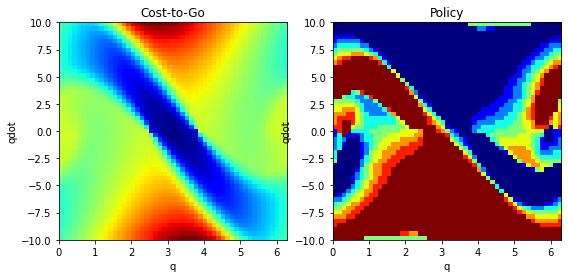

None

In [40]:
def pendulum_swingup_example(min_time=True, animate=True):
    plant = PendulumPlant()
    simulator = Simulator(plant)
    options = DynamicProgrammingOptions()

    qbins = np.linspace(0., 2. * np.pi, 51)
    qdotbins = np.linspace(-10., 10., 51)
    state_grid = [set(qbins), set(qdotbins)]
    options.periodic_boundary_conditions = [
        PeriodicBoundaryCondition(0, 0., 2. * np.pi),
    ]
    options.discount_factor = .999
    input_limit = 3.
    input_grid = [set(np.linspace(-input_limit, input_limit, 9))]
    timestep = 0.01

    [Q, Qdot] = np.meshgrid(qbins, qdotbins)

    meshcat.Delete()
    meshcat.SetProperty("/Background", "visible", False)

    def draw(iteration, mesh, cost_to_go, policy):
        # Don't draw every frame.
        if iteration % 20 != 0:
            return

        plot_surface(meshcat,
                     'Cost-to-go',
                     Q,
                     Qdot,
                     np.reshape(cost_to_go, Q.shape),
                     wireframe=True)
        plot_surface(meshcat,
                     'Policy',
                     Q,
                     Qdot,
                     np.reshape(policy, Q.shape),
                     rgba=Rgba(.3, .3, .5))

        # Slow down the algorithm so we can visualize the convergence.
        sleep(0.1)

    def simulate(policy):
        # Animate the resulting policy.
        builder = DiagramBuilder()
        pendulum = builder.AddSystem(PendulumPlant())

        wrap = builder.AddSystem(WrapToSystem(2))
        wrap.set_interval(0, 0, 2*np.pi)
        builder.Connect(pendulum.get_output_port(0), wrap.get_input_port(0))
        vi_policy = builder.AddSystem(policy)
        builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
        builder.Connect(vi_policy.get_output_port(0),
                        pendulum.get_input_port(0))

        visualizer = builder.AddSystem(
            PendulumVisualizer(show=False))
        builder.Connect(pendulum.get_output_port(0),
                        visualizer.get_input_port(0))

        diagram = builder.Build()
        simulator = Simulator(diagram)
        simulator.get_mutable_context().SetContinuousState([0.1, 0.0])

        AdvanceToAndVisualize(simulator, visualizer, 8.)

    if running_as_notebook:
        options.visualization_callback = draw

    def min_time_cost(context):
        x = context.get_continuous_state_vector().CopyToVector()
        x[0] = x[0] - np.pi
        if x.dot(x) < .05:
            return 0.
        return 1.

    def quadratic_regulator_cost(context):
        x = context.get_continuous_state_vector().CopyToVector()
        x[0] = x[0] - np.pi
        u = plant.EvalVectorInput(context, 0).CopyToVector()
        return 2 * x.dot(x) + u.dot(u)

    if min_time:
        cost_function = min_time_cost
        options.convergence_tol = 0.001
    else:
        cost_function = quadratic_regulator_cost
        options.convergence_tol = 0.1

    policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                              state_grid, input_grid, timestep,
                                              options)

    J = np.reshape(cost_to_go, Q.shape)

    plot_surface(meshcat, 'Cost-to-go', Q, Qdot, J, wireframe=True)

    if animate:
        print('Simulating...')
        simulate(policy)

    fig = plt.figure(figsize=(9, 4))
    ax1, ax2 = fig.subplots(1, 2)
    ax1.set_xlabel("q")
    ax1.set_ylabel("qdot")
    ax1.set_title("Cost-to-Go")
    ax2.set_xlabel("q")
    ax2.set_ylabel("qdot")
    ax2.set_title("Policy")
    ax1.imshow(J,
               cmap=cm.jet, aspect='auto',
               extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]))
    ax1.invert_yaxis()
    Pi = np.reshape(policy.get_output_values(), Q.shape)
    ax2.imshow(Pi,
               cmap=cm.jet, aspect='auto',
               extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]))
    ax2.invert_yaxis()
    display(plt.show())


pendulum_swingup_example(min_time=False, animate=True)

# Neural Fitted Value Iteration

In [41]:

# Define the double integrator
A = np.array([[0., 1.], [0., 0.]])
B = np.array([[0.], [1.]])
Q = 0.1*np.eye(2)
R = np.eye(1)

# vectorized
def min_time_cost(x, u):
    return 1.0 - np.isclose(x, np.zeros((2,1))).all(axis=0)

def quadratic_regulator_cost(x, u):
    return (x * (Q @ x)).sum(axis=0) + (u * (R @ u)).sum(axis=0)

def min_time_solution(x):
    # Caveat: this does not take the time discretization (zero-order hold on u) into account.
    q = x[0,:]
    qdot = x[1,:]
    # mask indicates that we are in the regime where u = +1.
    mask = ((qdot < 0) & (2 * q <=
                          (qdot**2))) | ((qdot >= 0) & (2 * q < -(qdot**2)))
    T = np.empty(q.size)
    T[mask] = 2*np.sqrt(.5*qdot[mask]**2 - q[mask]) - qdot[mask]
    T[~mask] = qdot[~mask] + 2*np.sqrt(.5*qdot[~mask]**2 + q[~mask])
    return T

def quadratic_regulator_solution(x, timestep, gamma=1):
    S = DiscreteAlgebraicRiccatiEquation(A=np.sqrt(gamma) *
                                         (np.eye(2) + timestep * A),
                                         B=timestep * B,
                                         Q=timestep * Q,
                                         R=timestep * R / gamma)
    return (x * (S @ x)).sum(axis=0)

def plot_and_compare(mlp, context, running_cost, timestep, gamma=1.0):
    x1s = np.linspace(-5,5,31)
    x2s = np.linspace(-4,4,51)
    X1s, X2s = np.meshgrid(x1s, x2s)
    N = X1s.size
    X = np.vstack((X1s.flatten(), X2s.flatten()))
    J = np.zeros((1,N))

    mlp.BatchOutput(context, X, J)

    plot_surface(meshcat,
                 "Jhat",
                 X1s,
                 X2s,
                 J.reshape(X1s.shape),
                rgba=Rgba(0,0,1),
                 wireframe=True)

    if running_cost == min_time_cost:
        Jd = min_time_solution(X)
    elif running_cost == quadratic_regulator_cost:
        Jd = quadratic_regulator_solution(X, timestep, gamma)

    plot_surface(meshcat,
                 "J_desired",
                 X1s,
                 X2s,
                 Jd.reshape(X1s.shape),
                 rgba=Rgba(1, 0, 0),
                 wireframe=True)


First, let's simply evaluate how well the network can fit the known cost-to-go functions (using supervised learning)

In [42]:
def SupervisedDemo(running_cost, timestep):
    x1s = np.linspace(-5,5,51)
    x2s = np.linspace(-4,4,51)
    X1s, X2s = np.meshgrid(x1s, x2s)
    N = X1s.size
    X = np.vstack((X1s.flatten(), X2s.flatten()))

    if running_cost == min_time_cost:
        Jd = min_time_solution(X)
    elif running_cost == quadratic_regulator_cost:
        Jd = quadratic_regulator_solution(X, timestep)

    Jd = Jd.reshape((1,N))

    mlp = MultilayerPerceptron(
        [2,100,100,1],
        [PerceptronActivationType.kReLU, 
         PerceptronActivationType.kReLU,
         PerceptronActivationType.kIdentity])
    context = mlp.CreateDefaultContext()
    generator = RandomGenerator(152)
    mlp.SetRandomContext(context, generator)

    optimizer = Adam(mlp.GetMutableParameters(context))

    dloss_dparams = np.zeros(mlp.num_parameters())
    last_loss = np.inf
    for epoch in range(1000 if running_as_notebook else 2):
        loss = mlp.BackpropagationMeanSquaredError(context, X, Jd,
                                                    dloss_dparams)
        clear_output(wait=True)
        print(f"loss = {loss}")
        if np.linalg.norm(last_loss - loss) < 0.0001:
            break
        last_loss = loss
        optimizer.step(loss, dloss_dparams)

    plot_and_compare(mlp, context, running_cost, timestep)

meshcat.Delete()
SupervisedDemo(min_time_cost, 0.1)
#SupervisedDemo(quadratic_regulator_cost, 0.1)

loss = 0.023814501084470217


## Discrete time, continuous state, discrete action

This is the standard "fitted value iteration" algorithm with a multilayer perceptron (MLP) as the function approximator, and a single step of gradient descent performed on each iteration.

In [43]:
def FittedValueIteration(running_cost, timestep):
    x1s = np.linspace(-5,5,31)
    x2s = np.linspace(-4,4,31)
    us = np.linspace(-1,1,9)
    Us, X1s, X2s = np.meshgrid(us, x1s, x2s, indexing='ij')
    XwithU = np.vstack((X1s.flatten(), X2s.flatten()))
    UwithX = Us.flatten().reshape(1,-1)
    Nx = x1s.size * x2s.size
    X = XwithU[:,:Nx]
    N = X1s.size

    Xnext = XwithU + timestep * (A @ XwithU + B @ UwithX)
    G = timestep*running_cost(XwithU, UwithX)
    Jnext = np.zeros((1,N))
    Jd = np.zeros((1,Nx))

    mlp = MultilayerPerceptron(
        [2,100,100,1] if running_cost == min_time_cost else [2, 16, 16, 1],
        [PerceptronActivationType.kReLU,
         PerceptronActivationType.kReLU,
         PerceptronActivationType.kIdentity])
    context = mlp.CreateDefaultContext()
    generator = RandomGenerator(123)
    mlp.SetRandomContext(context, generator)

    optimizer = Adam(mlp.GetMutableParameters(context))

    gamma = 0.9
    plot_and_compare(mlp, context, running_cost, timestep, gamma)
    dloss_dparams = np.zeros(mlp.num_parameters())
    last_loss = np.inf
    for epoch in range(500 if running_as_notebook else 2):
        mlp.BatchOutput(context, Xnext, Jnext)
        Jd[:] = np.min((G + gamma*Jnext).reshape(us.size, Nx), axis=0)
        for i in range(100 if running_as_notebook else 2):
            loss = mlp.BackpropagationMeanSquaredError(
                context, X, Jd, dloss_dparams)
            optimizer.step(loss, dloss_dparams)
        if np.linalg.norm(last_loss - loss) < 1e-8:
            break
        last_loss = loss
        clear_output(wait=True)
        print(f"epoch {epoch}: loss = {loss}")
        if epoch%10 == 0:
            plot_and_compare(mlp, context, running_cost, timestep, gamma)

    plot_and_compare(mlp, context, running_cost, timestep, gamma)

#FittedValueIteration(min_time_cost, 0.1)
FittedValueIteration(quadratic_regulator_cost, 0.1)

epoch 499: loss = 8.077048570948179e-05


## Continuous-time, state, and actions

I've written this to take an arbitrary system as the input.  It requires that the system has only continuous-time dynamics, and it assumes (currently without checking) that the system is control affine.

In [44]:
def ContinuousFittedValueIteration(plant,
                                   plant_context,
                                   value_mlp,
                                   state_cost_function,
                                   R_diag,
                                   state_samples,
                                   time_step=0.01,
                                   discount_factor=1.0,
                                   input_port_index=0,
                                   lr=0.001,
                                   minibatch=None,
                                   epochs=1000,
                                   optim_steps_per_epoch=25,
                                   input_limits=None):
    input_port = plant.get_input_port(input_port_index)
    num_states = plant.num_continuous_states()
    num_inputs = input_port.size()
    N = state_samples.shape[1]

    #assert plant.ValidateContext(plant_context)  # TODO(russt): bind this
    assert plant_context.has_only_continuous_state()
    assert value_mlp.get_input_port().size() == num_states
    assert value_mlp.layers()[-1] == 1
    assert R_diag.shape == (num_inputs,)
    assert state_samples.shape[0] == num_states
    assert time_step > 0.0
    assert discount_factor > 0.0 and discount_factor <= 1.0
    if input_limits != None:
        assert num_inputs == 1, "Input limits are only supported for scalar inputs (for now)"
        assert len(input_limits) == 2

    mlp_context = value_mlp.CreateDefaultContext()
    generator = RandomGenerator(123)
    value_mlp.SetRandomContext(mlp_context, generator)

    state_cost = state_cost_function(state_samples)
    state_dynamics_x = np.empty((N, num_states))
    dstate_dynamics_du = [np.empty((num_states, N))]*num_inputs
    Rinv = 1/R_diag

    state = plant_context.get_mutable_continuous_state_vector()

    # Precompute dynamics and cost (TODO: parallelize this).
    for i in range(N):
        u = np.zeros(num_inputs)
        input_port.FixValue(plant_context, u)
        state.SetFromVector(state_samples[:, i])
        state_dynamics_x[i] = plant.EvalTimeDerivatives(
            plant_context).CopyToVector()
        for j in range(num_inputs):
            u[j] = 1
            input_port.FixValue(plant_context, u)
            dstate_dynamics_du[j][:, i] = plant.EvalTimeDerivatives(
                plant_context).CopyToVector() - state_dynamics_x[i]
            u[j] = 0

    optimizer = Adam(value_mlp.GetMutableParameters(mlp_context), lr=lr)

    M = minibatch if minibatch else N
    J = np.zeros((1,M))
    Jnext = np.zeros((1,M))
    Jd = np.zeros((1,M))
    dJdX = np.asfortranarray(np.zeros((num_states, M)))
    dloss_dparams = np.zeros(value_mlp.num_parameters())
    last_loss = np.inf
    for epoch in range(epochs if running_as_notebook else 2):
        if minibatch:
            batch = np.random.randint(0, N, minibatch)
        else:
            batch = range(N)
        value_mlp.BatchOutput(mlp_context, state_samples[:,batch], J, dJdX)
        Xnext = state_samples[:,batch] + time_step*state_dynamics_x[batch,:].T
        G = state_cost[batch]
        for i in range(num_inputs):
            ui = -0.5*Rinv[i] * np.sum(dstate_dynamics_du[i][:,batch] * dJdX, 0)
            if input_limits != None:
                ui = np.minimum(np.maximum(ui, input_limits[0]),
                                input_limits[1])
            G += R_diag[i]*ui**2
            Xnext += time_step*dstate_dynamics_du[i][:,batch]*ui
        value_mlp.BatchOutput(mlp_context, Xnext, Jnext)
        Jd[:] = G*time_step + discount_factor*Jnext
        for i in range(optim_steps_per_epoch if running_as_notebook else 2):
            loss = value_mlp.BackpropagationMeanSquaredError(
                mlp_context, state_samples[:,batch], Jd, dloss_dparams)
            optimizer.step(loss, dloss_dparams)
        if not minibatch and np.linalg.norm(last_loss - loss) < 1e-8:
            break
        last_loss = loss
        if epoch % 20 == 0:
            clear_output(wait=True)
            print(f"epoch {epoch}: loss = {loss}")

    return mlp_context

class ContinuousFittedValueIterationPolicy(LeafSystem):

    def __init__(self,
                 plant,
                 value_mlp,
                 value_mlp_context,
                 R_diag,
                 input_port_index=0,
                 input_limits=None):
        LeafSystem.__init__(self)

        num_plant_states = value_mlp.get_input_port().size()
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()

        self.value_mlp = value_mlp
        self.value_mlp_context = value_mlp_context
        self.J = np.zeros((1,1))
        self.dJdX = np.asfortranarray(np.zeros((num_plant_states, 1)))

        self.Rinv = 1/R_diag
        self.input_limits = input_limits
        self.DeclareVectorInputPort("plant_state", num_plant_states)
        self._plant_input_port = self._plant.get_input_port(input_port_index)
        self.DeclareVectorOutputPort("output", self._plant_input_port.size(),
                                     self.CalcOutput)

    def CalcOutput(self, context, output):
        num_inputs = self._plant_input_port.size()
        u = np.zeros(num_inputs)
        plant_state = self.get_input_port().Eval(context)

        self.value_mlp.BatchOutput(self.value_mlp_context,
                                   np.atleast_2d(plant_state).T, self.J,
                                   self.dJdX)

        self._plant_context.SetContinuousState(plant_state)
        self._plant_input_port.FixValue(self._plant_context, u)
        state_dynamics_x = self._plant.EvalTimeDerivatives(
            self._plant_context).CopyToVector()
        for i in range(num_inputs):
            u[i] = 1
            self._plant_input_port.FixValue(self._plant_context, u)
            dstate_dynamics_dui = self._plant.EvalTimeDerivatives(
                self._plant_context).CopyToVector() - state_dynamics_x
            ui = -0.5 * self.Rinv[i] * dstate_dynamics_dui.dot(self.dJdX)
            if self.input_limits != None:
                ui = np.minimum(np.maximum(ui, self.input_limits[0]),
                                self.input_limits[1])
            output.SetAtIndex(i, ui)
            u[i] = 0


### Double Integrator

In [53]:
A = np.array([[0., 1.], [0., 0.]])
B = np.array([[0.], [1.]])
plant = LinearSystem(A,B, np.empty((0, 2)), np.empty((0, 1)))
plant_context = plant.CreateDefaultContext()

Q = np.eye(2)
def quadratic_regulator_state_cost(x):
    return (x * (Q @ x)).sum(axis=0)
R_diag = np.array([1])
R = np.eye(1)
time_step = 0.01
discount_factor = 0.9

value_mlp = MultilayerPerceptron(
        [2, 16, 16, 1],
        [PerceptronActivationType.kReLU,
         PerceptronActivationType.kReLU,
         PerceptronActivationType.kIdentity])

x1s = np.linspace(-5,5,31)
x2s = np.linspace(-4,4,31)
X1s, X2s = np.meshgrid(x1s, x2s, indexing='ij')
state_samples = np.vstack((X1s.flatten(), X2s.flatten()))
value_mlp_context = ContinuousFittedValueIteration(plant,
                                             plant_context,
                                             value_mlp,
                                             quadratic_regulator_state_cost,
                                             R_diag,
                                             state_samples,
                                             time_step=time_step,
                                             discount_factor=discount_factor)

meshcat.Delete()
meshcat.ResetRenderMode()
plot_and_compare(value_mlp, value_mlp_context, quadratic_regulator_cost,
                 time_step, discount_factor)


epoch 100: loss = 1.348207552884828e-05


### Pendulum

epoch 2980: loss = 0.24507046600298033


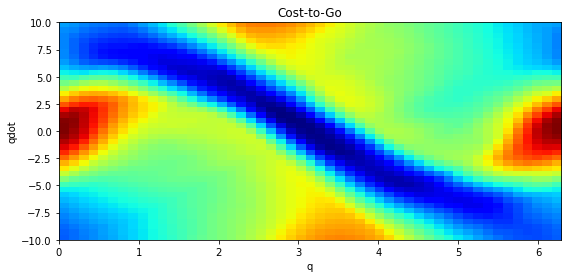

None

In [54]:
plant = PendulumPlant()
plant_context = plant.CreateDefaultContext()

Q = np.diag([10, 1])
def quadratic_regulator_state_cost(x):
    err = np.copy(x)
    err[0] -= np.pi
    return (err * (Q @ err)).sum(axis=0)
R_diag = np.array([1])
R = np.diag(R_diag)

value_mlp = MultilayerPerceptron(
        [True, False], [100, 100, 1],
        [PerceptronActivationType.kReLU,
         PerceptronActivationType.kReLU,
         PerceptronActivationType.kIdentity])

qs = np.linspace(0., 2. * np.pi, 51)
qdots = np.linspace(-10., 10., 41)
Qs, Qdots = np.meshgrid(qs, qdots)
state_samples = np.vstack((Qs.flatten(), Qdots.flatten()))
time_step = 0.01
discount_factor = .999
torque_limit = 3
value_mlp_context = ContinuousFittedValueIteration(
    plant,
    plant_context,
    value_mlp,
    quadratic_regulator_state_cost,
    R_diag,
    state_samples,
    time_step=time_step,
    discount_factor=discount_factor,
    minibatch=32,
    lr=1e-5,
    epochs=3000,
    optim_steps_per_epoch=100,
    input_limits=[-torque_limit, torque_limit])

J = value_mlp.BatchOutput(value_mlp_context, state_samples)
fig = plt.figure(1, figsize=(9, 4))
ax = fig.subplots()
ax.set_xlabel("q")
ax.set_ylabel("qdot")
ax.set_title("Cost-to-Go")
ax.imshow(J.reshape(qdots.size, qs.size),
          cmap=cm.jet,
          extent=(qs[0], qs[-1], qdots[-1], qdots[0]))
ax.invert_yaxis()
ax.axis('auto')
display(plt.show());


In [55]:
def simulate(value_mlp, value_mlp_context, R_diag):
    builder = DiagramBuilder()

    scene_graph = builder.AddSystem(SceneGraph())
    plant = builder.AddSystem(PendulumPlant())
    PendulumGeometry.AddToBuilder(builder, plant.get_state_output_port(),
                                  scene_graph)

    policy = builder.AddSystem(
        ContinuousFittedValueIterationPolicy(
            plant,
            value_mlp,
            value_mlp_context,
            R_diag,
            input_limits=[-torque_limit, torque_limit]))
    builder.Connect(plant.get_state_output_port(), policy.get_input_port())

    zoh = builder.AddSystem(ZeroOrderHold(time_step, 1))
    builder.Connect(policy.get_output_port(), zoh.get_input_port())
    builder.Connect(zoh.get_output_port(), plant.get_input_port())

    meshcat.Delete()
    meshcat.Set2dRenderMode(
        X_WC=RigidTransform(RotationMatrix.MakeZRotation(np.pi), [0, 1, 0]))
    vis = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    context.SetContinuousState([0.1, 0])
    #simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    vis.StartRecording(False)
    simulator.AdvanceTo(4)
    vis.PublishRecording()

simulate(value_mlp, value_mlp_context, R_diag)

### Acrobot

Note: I haven't quite finished this example yet!  (coming soon)

In [56]:
plant = AcrobotPlant()
plant_context = plant.CreateDefaultContext()

Q = np.diag([10, 10, 1, 1])
def quadratic_regulator_state_cost(x):
    err = np.copy(x)
    err[0] -= np.pi
    return (err * (Q @ err)).sum(axis=0)
R_diag = np.array([1])
R = np.diag(R_diag)

value_mlp = MultilayerPerceptron(
        [True, True, False, False], [32, 32, 1],
        [PerceptronActivationType.kReLU,
         PerceptronActivationType.kReLU,
         PerceptronActivationType.kIdentity])

q1s = np.linspace(0., 2. * np.pi, 21)
q2s = np.linspace(0., 2. * np.pi, 21)
q1dots = np.linspace(-10., 10., 11)
q2dots = np.linspace(-10., 10., 11)
Q1s, Q2s, Q1dots, Q2dots = np.meshgrid(q1s, q2s, q1dots, q2dots)
state_samples = np.vstack(
    (Q1s.flatten(), Q2s.flatten(), Q1dots.flatten(), Q2dots.flatten()))
time_step = 0.01
discount_factor = 0.95
mlp_context = ContinuousFittedValueIteration(plant,
                                             plant_context,
                                             value_mlp,
                                             quadratic_regulator_state_cost,
                                             R_diag,
                                             state_samples,
                                             time_step=time_step,
                                             discount_factor=discount_factor,
                                             lr=1e-5,
                                             minibatch=500)


epoch 980: loss = 4.260169539781864


# Sums-of-squares Dynamic Programming

## Cubic polynomial optimal control

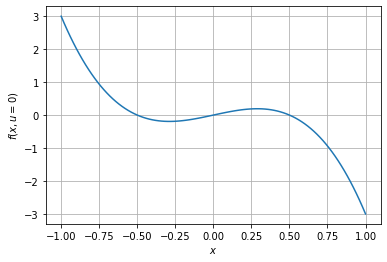

In [49]:
# Scalar dynamics.
f = lambda x, u : x - 4 * x ** 3 + u
# Quadratic running cost.
l = lambda x, u : x ** 2 + u ** 2
# Input limits.
U = [-1, 1]
# State limits (region of state space where we approximate the value function).
X = [-1, 1]

# Numerically integrate the solution to the HJB to get the "true" optimal
# cost-to-go; this only works in the scalar case when we can compute the
# optimal policy explicitly as a function of dJdx. TODO: Use Drake's
# InitialValueProblem after cleanup proposed in
# https://github.com/RobotLocomotion/drake/issues/12857 happens.
def optimal_cost_to_go():
    x = Variable('x')
    J = Variable('J')
    builder = DiagramBuilder()
    sys = builder.AddSystem(
        SymbolicVectorSystem(time=x,
                             state=[J],
                             dynamics=[
                                 2 * (x - 4 * x**3)
                                 + 2 * x * np.sqrt(2 - 8 * x**2 + 16 * x**4)
                             ], output=[J]))
    logger = LogVectorOutput(sys.get_output_port(), builder)
    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    # Set J(0) = 0
    context.SetTime(0.0)
    context.SetContinuousState([0.0])
    simulator.AdvanceTo(1.0)
    log = logger.FindLog(context)
    return log.sample_times(), log.data()


# Plot dynamics with zero input.
n_breaks = 101
x_breaks = np.linspace(*X, n_breaks)
plt.plot(x_breaks, f(x_breaks, np.zeros(n_breaks)))
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x, u=0)$')
plt.grid(True)

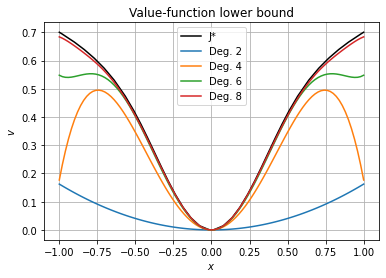

In [50]:


# Given the degree for the approximate value function and the polynomials
# in the S procedure, solves the SOS and returns the approximate value function
# (together with the objective of the SOS program).
def sos_dp(deg):
    
    # Set up SOS program.
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(1, 'x')[0]
    u = prog.NewIndeterminates(1, 'u')[0]
    J = prog.NewFreePolynomial(Variables([x]), deg)

    # Maximize volume beneath the value function.
    J_int = J.Integrate(x, -1, 1).ToExpression()
    prog.AddLinearCost(- J_int)
    
    # S-procedure for the input limits.
    xu = Variables([x, u])
    lamx = prog.NewSosPolynomial(xu, deg)[0]
    S_procedure = lamx * Polynomial((x - X[0]) * (X[1] - x))
    
    # S-procedure for the input limits.
    lamu = prog.NewSosPolynomial(xu, deg)[0]
    S_procedure += lamu * Polynomial((u - U[0]) * (U[1] - u))
    
    # Enforce Bellman inequality.
    J_dot = J.Differentiate(x) * Polynomial(f(x, u))
    prog.AddSosConstraint(J_dot + Polynomial(l(x, u)) - S_procedure)

    # J(0) = 0.
    prog.AddLinearConstraint(J.EvaluatePartial({x: 0}).ToExpression() == 0)

    # Solve and retrieve result.
    result = Solve(prog)
    assert result.is_success()

    # retrieve value function
    J_opt_expr = result.GetSolution(J.ToExpression())
    J_opt = lambda x_eval: J_opt_expr.Evaluate({x: x_eval})
    cost = - result.get_optimal_cost()
    
    return J_opt, cost

# Solve for increasing degree.
degrees = np.arange(1, 5) * 2
J = {deg: sos_dp(deg) for deg in degrees}

# Plot solution.
x_opt, J_opt = optimal_cost_to_go()
plt.figure()
plt.plot(x_opt, J_opt.T, 'k', label='J*')
plt.plot(-x_opt, J_opt.T, 'k')
for deg in degrees:
    label = f'Deg. {deg}'
    J_plot = [J[deg][0](xi) for xi in x_breaks]
    plt.plot(x_breaks, J_plot, label=label)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$v$')
    plt.title('Value-function lower bound')
    plt.legend()
    plt.grid(True)

In [51]:
# System dimensions. Here:
# x = [theta, theta_dot]
# z = [sin(theta), cos(theta), theta_dot]
nx = 2
nz = 3
nu = 1

# Map from original state to augmented state.
# Uses sympy to be able to do symbolic integration later on.
x2z = lambda x : np.array([np.sin(x[0]), np.cos(x[0]), x[1]])

# System dynamics in augmented state (z).
params = PendulumParams()
inertia = params.mass() * params.length() ** 2
tau_g = params.mass() * params.gravity() * params.length()
def f(z, u):
    return [
        z[1] * z[2],
        - z[0] * z[2],
        (tau_g * z[0] + u[0] - params.damping() * z[2]) / inertia
    ]

# State limits (region of state space where we approximate the value function).
x_max = np.array([np.pi, 2*np.pi])
x_min = - x_max
z_max = x2z(x_max)
z_min = x2z(x_min)

# Equilibrium point in both the system coordinates.
x0 = np.array([0, 0])
z0 = x2z(x0)
    
# Quadratic running cost in augmented state.
Q = np.diag([1, 1, 1])
R = np.diag([5])
def l(z, u):
    return (z - z0).dot(Q).dot(z - z0) + u.dot(R).dot(u)

Note: Use deg=10 for a nice swing-up, but the open-source solver (C-SDP) only seems to be able to handle degree up to 5.

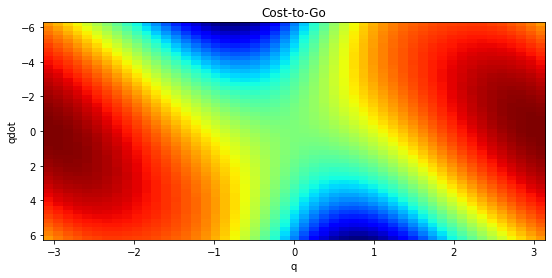

In [52]:
# Given the degree for the approximate value function and the polynomials
# in the S procedure, solves the SOS and returns the approximate value function
# (together with the objective of the SOS program).
def sos_dp(deg):

    # Set up optimization.
    prog = MathematicalProgram()
    z = prog.NewIndeterminates(nz, 'z')
    u = prog.NewIndeterminates(nu, 'u')
    J = prog.NewFreePolynomial(Variables(z), deg)
    J_expr = J.ToExpression()

    # Maximize volume beneath the value function.
    obj = J
    for i in range(nz):
        obj = obj.Integrate(z[i], z_min[i], z_max[i])
    prog.AddLinearCost(- obj.ToExpression())

    # S procedure for s^2 + c^2 = 1.
    lam = prog.NewFreePolynomial(Variables(z), deg).ToExpression()
    S_procedure = lam * (z[0]**2 + z[1]**2 - 1)

    # Enforce Bellman inequality.
    J_dot = J_expr.Jacobian(z).dot(f(z, u))
    prog.AddSosConstraint(J_dot + l(z, u) + S_procedure)

    # J(z0) = 0.
    J0 = J_expr.EvaluatePartial(dict(zip(z, z0)))
    prog.AddLinearConstraint(J0 == 0)

    # Solve and retrieve result.
    result = Solve(prog)
    assert result.is_success()
    J_star = Polynomial(result.GetSolution(J_expr))

    # Solve for the optimal feedback in augmented coordinates.
    Rinv = np.linalg.inv(R)
    f2 = np.array([[0], [0], [1 / inertia]])
    dJdz = J_star.ToExpression().Jacobian(z)
    u_star = - .5 * Rinv.dot(f2.T).dot(dJdz.T)

    return J_star, u_star, z

J_star, u_star, z = sos_dp(deg=4)

X1, X2 = np.meshgrid(np.linspace(x_min[0], x_max[0], 51),
                     np.linspace(x_min[1], x_max[1], 51))
X = np.vstack((X1.flatten(), X2.flatten()))
Z = x2z(X)
J = np.zeros(Z.shape[1])
for i in range(Z.shape[1]):
    J[i] = J_star.Evaluate({z[0]: Z[0, i], z[1]: Z[1, i], z[2]: Z[2, i]})

fig = plt.figure(figsize=(9, 4))
ax = fig.subplots()
ax.set_xlabel("q")
ax.set_ylabel("qdot")
ax.set_title("Cost-to-Go")
ax.imshow(J.reshape(X1.shape),
        cmap=cm.jet, aspect='auto',
        extent=(x_min[0], x_max[0], x_min[1], x_max[1]))
ax.invert_yaxis()
